In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from tqdm import tqdm
import backbone
from dataloader import create_dataloader

# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.00001
image_size = 384
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../mured-data/data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# # Create model and move to device
# model = backbone.backbone['densenet201'](num_classes=num_classes)
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Create model and move to device
model = backbone.backbone['resnet152v2'](num_classes=num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
# # Create model and move to device
# model = backbone.backbone['efficientnetv2_extralarge'](num_classes=num_classes)
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
# create empty lists to store predicted probabilities and true labels for each epoch
train_preds_all, train_labels_all = [], []
val_preds_all, val_labels_all = [], []
# create a list to store the ROC plots
roc_plots = []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]
#roc_epochs = [int(num_epochs / 4), int(num_epochs / 2), int(3 * num_epochs / 4), num_epochs]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        train_preds += outputs.sigmoid().tolist()
        train_labels += labels.tolist()


    epoch_loss_train = running_loss / len(train_dataloader)
    print(f"Training Loss: {epoch_loss_train:.4f}")
    
    # calculate ROC AUC score for train set
    train_roc_auc = roc_auc_score(train_labels, train_preds)
    print(f"Train ROC AUC Score: {train_roc_auc:.4f}")
    
    # append the predicted probabilities and true labels for this epoch to the lists for all epochs
    train_preds_all.append(train_preds)
    train_labels_all.append(train_labels)

    # Validation phase
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    for inputs, labels in tqdm(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())

            running_loss += loss.item()

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.sigmoid().tolist()
        val_labels += labels.tolist()

    epoch_loss_val = running_loss / len(val_dataloader)
    print(f"Validation Loss: {epoch_loss_val:.4f}")

    # calculate ROC AUC score for validation set
    val_roc_auc = roc_auc_score(val_labels, val_preds)
    print(f"Validation ROC AUC Score: {val_roc_auc:.4f}")
    
    # append the predicted probabilities and true labels for this epoch to the lists for all epochs
    val_preds_all.append(val_preds)
    val_labels_all.append(val_labels)
    
    # calculate F1 score for validation set using the defined thresholds
    val_preds_thresholded = [[1 if pred[i] >= thresholds[i] else 0 for i in range(num_labels)] for pred in val_preds]
    val_f1_score = f1_score(val_labels, val_preds_thresholded, average='macro')
    print(f"Validation F1 Score: {val_f1_score:.4f}")
        
    f1_arr.append(val_f1_score)
    loss_arr.append(epoch_loss_val)
    
    # check if the current epoch is in the list of epochs to plot ROC curve
    if epoch+1 in roc_epochs:
        # calculate ROC curve and AUC score for validation set
        fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
        roc_fpr.append(fpr)
        roc_tpr.append(tpr)
        roc_auc.append(auc(fpr, tpr))

    print() # empty line for spacing

Epoch 1/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.20it/s]


Training Loss: 4.7995
Train ROC AUC Score: 0.5546


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 3.6598
Validation ROC AUC Score: 0.6225
Validation F1 Score: 0.1362

Epoch 2/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 4.6652
Train ROC AUC Score: 0.6478


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 3.5910
Validation ROC AUC Score: 0.7295
Validation F1 Score: 0.1649

Epoch 3/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 4.5942
Train ROC AUC Score: 0.7272


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 3.5122
Validation ROC AUC Score: 0.7789
Validation F1 Score: 0.1916

Epoch 4/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 4.5527
Train ROC AUC Score: 0.7703


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 3.4379
Validation ROC AUC Score: 0.8055
Validation F1 Score: 0.1886

Epoch 5/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 4.3317
Train ROC AUC Score: 0.7836


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 3.3147
Validation ROC AUC Score: 0.8160
Validation F1 Score: 0.1992

Epoch 6/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 4.1756
Train ROC AUC Score: 0.7985


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 3.2082
Validation ROC AUC Score: 0.8309
Validation F1 Score: 0.2066

Epoch 7/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 4.0896
Train ROC AUC Score: 0.8114


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 3.0953
Validation ROC AUC Score: 0.8407
Validation F1 Score: 0.2111

Epoch 8/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.24it/s]


Training Loss: 3.9176
Train ROC AUC Score: 0.8181


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 2.9504
Validation ROC AUC Score: 0.8510
Validation F1 Score: 0.2189

Epoch 9/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.24it/s]


Training Loss: 3.8386
Train ROC AUC Score: 0.8409


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Validation Loss: 2.8447
Validation ROC AUC Score: 0.8580
Validation F1 Score: 0.2215

Epoch 10/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 3.7055
Train ROC AUC Score: 0.8471


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 2.7459
Validation ROC AUC Score: 0.8655
Validation F1 Score: 0.2162

Epoch 11/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 3.5804
Train ROC AUC Score: 0.8640


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 2.6356
Validation ROC AUC Score: 0.8729
Validation F1 Score: 0.2190

Epoch 12/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 3.3693
Train ROC AUC Score: 0.8698


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 2.5368
Validation ROC AUC Score: 0.8763
Validation F1 Score: 0.2186

Epoch 13/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 3.3094
Train ROC AUC Score: 0.8764


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 2.4539
Validation ROC AUC Score: 0.8828
Validation F1 Score: 0.2216

Epoch 14/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 3.1883
Train ROC AUC Score: 0.8873


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 2.4101
Validation ROC AUC Score: 0.8880
Validation F1 Score: 0.2219

Epoch 15/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 3.1265
Train ROC AUC Score: 0.8963


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 2.3438
Validation ROC AUC Score: 0.8932
Validation F1 Score: 0.2311

Epoch 16/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 3.0152
Train ROC AUC Score: 0.9076


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 2.2668
Validation ROC AUC Score: 0.8959
Validation F1 Score: 0.2284

Epoch 17/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.22it/s]


Training Loss: 2.9182
Train ROC AUC Score: 0.9100


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 2.1885
Validation ROC AUC Score: 0.9022
Validation F1 Score: 0.2389

Epoch 18/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 2.8521
Train ROC AUC Score: 0.9145


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 2.1574
Validation ROC AUC Score: 0.9025
Validation F1 Score: 0.2473

Epoch 19/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 2.8043
Train ROC AUC Score: 0.9197


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 2.0762
Validation ROC AUC Score: 0.9047
Validation F1 Score: 0.2431

Epoch 20/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 2.6981
Train ROC AUC Score: 0.9262


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Validation Loss: 2.0486
Validation ROC AUC Score: 0.9092
Validation F1 Score: 0.2488

Epoch 21/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 2.6884
Train ROC AUC Score: 0.9219


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 2.0165
Validation ROC AUC Score: 0.9101
Validation F1 Score: 0.2505

Epoch 22/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 2.5807
Train ROC AUC Score: 0.9341


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.9773
Validation ROC AUC Score: 0.9125
Validation F1 Score: 0.2458

Epoch 23/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 2.6147
Train ROC AUC Score: 0.9352


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.9411
Validation ROC AUC Score: 0.9149
Validation F1 Score: 0.2472

Epoch 24/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 2.4455
Train ROC AUC Score: 0.9433


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.9525
Validation ROC AUC Score: 0.9162
Validation F1 Score: 0.2484

Epoch 25/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 2.4988
Train ROC AUC Score: 0.9461


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.9861
Validation ROC AUC Score: 0.9172
Validation F1 Score: 0.2549

Epoch 26/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 2.3387
Train ROC AUC Score: 0.9472


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.8650
Validation ROC AUC Score: 0.9222
Validation F1 Score: 0.2582

Epoch 27/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 2.4094
Train ROC AUC Score: 0.9428


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Validation Loss: 1.9047
Validation ROC AUC Score: 0.9223
Validation F1 Score: 0.2526

Epoch 28/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 2.3319
Train ROC AUC Score: 0.9477


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.8329
Validation ROC AUC Score: 0.9207
Validation F1 Score: 0.2582

Epoch 29/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 2.3114
Train ROC AUC Score: 0.9564


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Validation Loss: 1.8873
Validation ROC AUC Score: 0.9202
Validation F1 Score: 0.2594

Epoch 30/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 2.2298
Train ROC AUC Score: 0.9540


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.8396
Validation ROC AUC Score: 0.9207
Validation F1 Score: 0.2571

Epoch 31/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 2.1387
Train ROC AUC Score: 0.9591


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7738
Validation ROC AUC Score: 0.9225
Validation F1 Score: 0.2591

Epoch 32/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 2.1194
Train ROC AUC Score: 0.9592


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.8100
Validation ROC AUC Score: 0.9248
Validation F1 Score: 0.2639

Epoch 33/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 2.0979
Train ROC AUC Score: 0.9621


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.8045
Validation ROC AUC Score: 0.9258
Validation F1 Score: 0.2589

Epoch 34/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 2.0894
Train ROC AUC Score: 0.9632


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.7819
Validation ROC AUC Score: 0.9258
Validation F1 Score: 0.2638

Epoch 35/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 2.0769
Train ROC AUC Score: 0.9614


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7922
Validation ROC AUC Score: 0.9235
Validation F1 Score: 0.2634

Epoch 36/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 2.0448
Train ROC AUC Score: 0.9663


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7600
Validation ROC AUC Score: 0.9256
Validation F1 Score: 0.2671

Epoch 37/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 2.0814
Train ROC AUC Score: 0.9658


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7351
Validation ROC AUC Score: 0.9264
Validation F1 Score: 0.2703

Epoch 38/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.9690
Train ROC AUC Score: 0.9672


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.7294
Validation ROC AUC Score: 0.9284
Validation F1 Score: 0.2729

Epoch 39/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.27it/s]


Training Loss: 1.9584
Train ROC AUC Score: 0.9725


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7146
Validation ROC AUC Score: 0.9280
Validation F1 Score: 0.2748

Epoch 40/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.27it/s]


Training Loss: 2.0437
Train ROC AUC Score: 0.9695


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.7193
Validation ROC AUC Score: 0.9296
Validation F1 Score: 0.2720

Epoch 41/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.9170
Train ROC AUC Score: 0.9724


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7281
Validation ROC AUC Score: 0.9305
Validation F1 Score: 0.2685

Epoch 42/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.8786
Train ROC AUC Score: 0.9721


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7083
Validation ROC AUC Score: 0.9311
Validation F1 Score: 0.2728

Epoch 43/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.8201
Train ROC AUC Score: 0.9752


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7212
Validation ROC AUC Score: 0.9282
Validation F1 Score: 0.2726

Epoch 44/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.8607
Train ROC AUC Score: 0.9758


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7394
Validation ROC AUC Score: 0.9289
Validation F1 Score: 0.2793

Epoch 45/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.8140
Train ROC AUC Score: 0.9757


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7193
Validation ROC AUC Score: 0.9291
Validation F1 Score: 0.2830

Epoch 46/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.7987
Train ROC AUC Score: 0.9783


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7321
Validation ROC AUC Score: 0.9310
Validation F1 Score: 0.2786

Epoch 47/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.8879
Train ROC AUC Score: 0.9773


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7007
Validation ROC AUC Score: 0.9321
Validation F1 Score: 0.2807

Epoch 48/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.7955
Train ROC AUC Score: 0.9775


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7167
Validation ROC AUC Score: 0.9320
Validation F1 Score: 0.2830

Epoch 49/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.7804
Train ROC AUC Score: 0.9811


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7321
Validation ROC AUC Score: 0.9334
Validation F1 Score: 0.2770

Epoch 50/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.7442
Train ROC AUC Score: 0.9799


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7413
Validation ROC AUC Score: 0.9319
Validation F1 Score: 0.2940

Epoch 51/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.7109
Train ROC AUC Score: 0.9806


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7683
Validation ROC AUC Score: 0.9292
Validation F1 Score: 0.2990

Epoch 52/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.6749
Train ROC AUC Score: 0.9819


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6878
Validation ROC AUC Score: 0.9315
Validation F1 Score: 0.2929

Epoch 53/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.6942
Train ROC AUC Score: 0.9816


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Validation Loss: 1.6538
Validation ROC AUC Score: 0.9325
Validation F1 Score: 0.2916

Epoch 54/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.7115
Train ROC AUC Score: 0.9827


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7014
Validation ROC AUC Score: 0.9324
Validation F1 Score: 0.2855

Epoch 55/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.6585
Train ROC AUC Score: 0.9831


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6621
Validation ROC AUC Score: 0.9334
Validation F1 Score: 0.2867

Epoch 56/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.5415
Train ROC AUC Score: 0.9851


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7419
Validation ROC AUC Score: 0.9331
Validation F1 Score: 0.2953

Epoch 57/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.6505
Train ROC AUC Score: 0.9831


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6830
Validation ROC AUC Score: 0.9347
Validation F1 Score: 0.2952

Epoch 58/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.6074
Train ROC AUC Score: 0.9845


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.7304
Validation ROC AUC Score: 0.9320
Validation F1 Score: 0.2999

Epoch 59/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.6606
Train ROC AUC Score: 0.9824


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.7235
Validation ROC AUC Score: 0.9331
Validation F1 Score: 0.3015

Epoch 60/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.6600
Train ROC AUC Score: 0.9850


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7019
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.3007

Epoch 61/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.6028
Train ROC AUC Score: 0.9847


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.6946
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.3054

Epoch 62/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.5257
Train ROC AUC Score: 0.9865


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7092
Validation ROC AUC Score: 0.9335
Validation F1 Score: 0.3011

Epoch 63/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.5695
Train ROC AUC Score: 0.9868


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6884
Validation ROC AUC Score: 0.9339
Validation F1 Score: 0.3015

Epoch 64/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.5477
Train ROC AUC Score: 0.9883


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7645
Validation ROC AUC Score: 0.9320
Validation F1 Score: 0.3108

Epoch 65/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.5574
Train ROC AUC Score: 0.9872


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7353
Validation ROC AUC Score: 0.9344
Validation F1 Score: 0.3083

Epoch 66/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.5391
Train ROC AUC Score: 0.9886


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Validation Loss: 1.7058
Validation ROC AUC Score: 0.9348
Validation F1 Score: 0.3110

Epoch 67/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.5390
Train ROC AUC Score: 0.9877


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Validation Loss: 1.6975
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.3102

Epoch 68/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.5021
Train ROC AUC Score: 0.9876


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7093
Validation ROC AUC Score: 0.9330
Validation F1 Score: 0.3102

Epoch 69/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.5481
Train ROC AUC Score: 0.9875


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Validation Loss: 1.6974
Validation ROC AUC Score: 0.9349
Validation F1 Score: 0.3123

Epoch 70/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.4971
Train ROC AUC Score: 0.9893


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.6975
Validation ROC AUC Score: 0.9386
Validation F1 Score: 0.3138

Epoch 71/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.5210
Train ROC AUC Score: 0.9890


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7037
Validation ROC AUC Score: 0.9375
Validation F1 Score: 0.3094

Epoch 72/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.4795
Train ROC AUC Score: 0.9900


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7033
Validation ROC AUC Score: 0.9353
Validation F1 Score: 0.3250

Epoch 73/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.4572
Train ROC AUC Score: 0.9900


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.7208
Validation ROC AUC Score: 0.9375
Validation F1 Score: 0.3114

Epoch 74/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.4121
Train ROC AUC Score: 0.9909


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.6892
Validation ROC AUC Score: 0.9383
Validation F1 Score: 0.3131

Epoch 75/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.5381
Train ROC AUC Score: 0.9898


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7353
Validation ROC AUC Score: 0.9375
Validation F1 Score: 0.3141

Epoch 76/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.4006
Train ROC AUC Score: 0.9907


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6822
Validation ROC AUC Score: 0.9370
Validation F1 Score: 0.3169

Epoch 77/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.4098
Train ROC AUC Score: 0.9902


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7154
Validation ROC AUC Score: 0.9331
Validation F1 Score: 0.3192

Epoch 78/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.3905
Train ROC AUC Score: 0.9917


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.6759
Validation ROC AUC Score: 0.9328
Validation F1 Score: 0.3188

Epoch 79/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.4060
Train ROC AUC Score: 0.9916


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7118
Validation ROC AUC Score: 0.9323
Validation F1 Score: 0.3221

Epoch 80/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.4601
Train ROC AUC Score: 0.9906


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.6844
Validation ROC AUC Score: 0.9352
Validation F1 Score: 0.3287

Epoch 81/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.3826
Train ROC AUC Score: 0.9916


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Validation Loss: 1.6932
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.3276

Epoch 82/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.3752
Train ROC AUC Score: 0.9922


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Validation Loss: 1.6757
Validation ROC AUC Score: 0.9349
Validation F1 Score: 0.3156

Epoch 83/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.3812
Train ROC AUC Score: 0.9923


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7307
Validation ROC AUC Score: 0.9349
Validation F1 Score: 0.3210

Epoch 84/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.4452
Train ROC AUC Score: 0.9930


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6801
Validation ROC AUC Score: 0.9366
Validation F1 Score: 0.3223

Epoch 85/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.3556
Train ROC AUC Score: 0.9924


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7455
Validation ROC AUC Score: 0.9335
Validation F1 Score: 0.3389

Epoch 86/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.3767
Train ROC AUC Score: 0.9916


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6809
Validation ROC AUC Score: 0.9363
Validation F1 Score: 0.3373

Epoch 87/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.3535
Train ROC AUC Score: 0.9928


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.6537
Validation ROC AUC Score: 0.9368
Validation F1 Score: 0.3235

Epoch 88/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.2930
Train ROC AUC Score: 0.9930


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6881
Validation ROC AUC Score: 0.9334
Validation F1 Score: 0.3296

Epoch 89/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.3026
Train ROC AUC Score: 0.9931


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Validation Loss: 1.6995
Validation ROC AUC Score: 0.9357
Validation F1 Score: 0.3221

Epoch 90/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.3432
Train ROC AUC Score: 0.9931


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6998
Validation ROC AUC Score: 0.9359
Validation F1 Score: 0.3225

Epoch 91/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.3647
Train ROC AUC Score: 0.9931


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.6516
Validation ROC AUC Score: 0.9362
Validation F1 Score: 0.3291

Epoch 92/200
----------


100%|██████████| 111/111 [00:47<00:00,  2.32it/s]


Training Loss: 1.3312
Train ROC AUC Score: 0.9942


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Validation Loss: 1.6983
Validation ROC AUC Score: 0.9345
Validation F1 Score: 0.3226

Epoch 93/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.3293
Train ROC AUC Score: 0.9929


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.6962
Validation ROC AUC Score: 0.9358
Validation F1 Score: 0.3333

Epoch 94/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.2902
Train ROC AUC Score: 0.9941


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.6677
Validation ROC AUC Score: 0.9334
Validation F1 Score: 0.3335

Epoch 95/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.2823
Train ROC AUC Score: 0.9940


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Validation Loss: 1.6807
Validation ROC AUC Score: 0.9334
Validation F1 Score: 0.3354

Epoch 96/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.3863
Train ROC AUC Score: 0.9929


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6543
Validation ROC AUC Score: 0.9349
Validation F1 Score: 0.3364

Epoch 97/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.3489
Train ROC AUC Score: 0.9926


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.6850
Validation ROC AUC Score: 0.9365
Validation F1 Score: 0.3345

Epoch 98/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.2559
Train ROC AUC Score: 0.9944


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7335
Validation ROC AUC Score: 0.9368
Validation F1 Score: 0.3466

Epoch 99/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.2906
Train ROC AUC Score: 0.9946


100%|██████████| 28/28 [00:10<00:00,  2.79it/s]


Validation Loss: 1.7190
Validation ROC AUC Score: 0.9361
Validation F1 Score: 0.3385

Epoch 100/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.2894
Train ROC AUC Score: 0.9950


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7084
Validation ROC AUC Score: 0.9377
Validation F1 Score: 0.3436

Epoch 101/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.2747
Train ROC AUC Score: 0.9950


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7129
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.3418

Epoch 102/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.2612
Train ROC AUC Score: 0.9943


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7353
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.3458

Epoch 103/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.2802
Train ROC AUC Score: 0.9955


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7426
Validation ROC AUC Score: 0.9350
Validation F1 Score: 0.3500

Epoch 104/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2786
Train ROC AUC Score: 0.9949


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.7373
Validation ROC AUC Score: 0.9338
Validation F1 Score: 0.3464

Epoch 105/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2572
Train ROC AUC Score: 0.9952


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7070
Validation ROC AUC Score: 0.9374
Validation F1 Score: 0.3472

Epoch 106/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.1968
Train ROC AUC Score: 0.9953


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7060
Validation ROC AUC Score: 0.9384
Validation F1 Score: 0.3461

Epoch 107/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2989
Train ROC AUC Score: 0.9946


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7396
Validation ROC AUC Score: 0.9368
Validation F1 Score: 0.3479

Epoch 108/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.3158
Train ROC AUC Score: 0.9949


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7187
Validation ROC AUC Score: 0.9370
Validation F1 Score: 0.3451

Epoch 109/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2786
Train ROC AUC Score: 0.9954


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.6875
Validation ROC AUC Score: 0.9372
Validation F1 Score: 0.3409

Epoch 110/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.1824
Train ROC AUC Score: 0.9961


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Validation Loss: 1.6827
Validation ROC AUC Score: 0.9389
Validation F1 Score: 0.3441

Epoch 111/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2735
Train ROC AUC Score: 0.9958


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7484
Validation ROC AUC Score: 0.9372
Validation F1 Score: 0.3494

Epoch 112/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.1685
Train ROC AUC Score: 0.9961


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Validation Loss: 1.7246
Validation ROC AUC Score: 0.9369
Validation F1 Score: 0.3481

Epoch 113/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2204
Train ROC AUC Score: 0.9961


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7177
Validation ROC AUC Score: 0.9345
Validation F1 Score: 0.3493

Epoch 114/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.2326
Train ROC AUC Score: 0.9965


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.7400
Validation ROC AUC Score: 0.9365
Validation F1 Score: 0.3523

Epoch 115/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.2120
Train ROC AUC Score: 0.9963


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7262
Validation ROC AUC Score: 0.9383
Validation F1 Score: 0.3508

Epoch 116/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.2033
Train ROC AUC Score: 0.9960


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7748
Validation ROC AUC Score: 0.9367
Validation F1 Score: 0.3546

Epoch 117/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.1819
Train ROC AUC Score: 0.9961


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Validation Loss: 1.7389
Validation ROC AUC Score: 0.9373
Validation F1 Score: 0.3546

Epoch 118/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.1553
Train ROC AUC Score: 0.9960


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7589
Validation ROC AUC Score: 0.9344
Validation F1 Score: 0.3514

Epoch 119/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.2532
Train ROC AUC Score: 0.9962


100%|██████████| 28/28 [00:09<00:00,  2.81it/s]


Validation Loss: 1.7480
Validation ROC AUC Score: 0.9346
Validation F1 Score: 0.3442

Epoch 120/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.23it/s]


Training Loss: 1.2716
Train ROC AUC Score: 0.9961


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7104
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.3541

Epoch 121/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.2286
Train ROC AUC Score: 0.9967


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7685
Validation ROC AUC Score: 0.9338
Validation F1 Score: 0.3520

Epoch 122/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1964
Train ROC AUC Score: 0.9972


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7509
Validation ROC AUC Score: 0.9376
Validation F1 Score: 0.3482

Epoch 123/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.1911
Train ROC AUC Score: 0.9969


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.6976
Validation ROC AUC Score: 0.9356
Validation F1 Score: 0.3554

Epoch 124/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.1961
Train ROC AUC Score: 0.9963


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7482
Validation ROC AUC Score: 0.9356
Validation F1 Score: 0.3635

Epoch 125/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2100
Train ROC AUC Score: 0.9968


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Validation Loss: 1.7126
Validation ROC AUC Score: 0.9380
Validation F1 Score: 0.3647

Epoch 126/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1176
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7000
Validation ROC AUC Score: 0.9370
Validation F1 Score: 0.3603

Epoch 127/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2445
Train ROC AUC Score: 0.9965


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Validation Loss: 1.6958
Validation ROC AUC Score: 0.9372
Validation F1 Score: 0.3563

Epoch 128/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1816
Train ROC AUC Score: 0.9968


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.7257
Validation ROC AUC Score: 0.9374
Validation F1 Score: 0.3602

Epoch 129/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2424
Train ROC AUC Score: 0.9970


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7353
Validation ROC AUC Score: 0.9352
Validation F1 Score: 0.3690

Epoch 130/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.1831
Train ROC AUC Score: 0.9970


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.6870
Validation ROC AUC Score: 0.9361
Validation F1 Score: 0.3599

Epoch 131/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2294
Train ROC AUC Score: 0.9968


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7274
Validation ROC AUC Score: 0.9362
Validation F1 Score: 0.3594

Epoch 132/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.1358
Train ROC AUC Score: 0.9969


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.7842
Validation ROC AUC Score: 0.9325
Validation F1 Score: 0.3659

Epoch 133/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1951
Train ROC AUC Score: 0.9968


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7215
Validation ROC AUC Score: 0.9379
Validation F1 Score: 0.3565

Epoch 134/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.2353
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Validation Loss: 1.7122
Validation ROC AUC Score: 0.9377
Validation F1 Score: 0.3634

Epoch 135/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.1703
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.6868
Validation ROC AUC Score: 0.9368
Validation F1 Score: 0.3542

Epoch 136/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.2825
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.7114
Validation ROC AUC Score: 0.9351
Validation F1 Score: 0.3674

Epoch 137/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1566
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7503
Validation ROC AUC Score: 0.9351
Validation F1 Score: 0.3687

Epoch 138/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1967
Train ROC AUC Score: 0.9974


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7821
Validation ROC AUC Score: 0.9349
Validation F1 Score: 0.3608

Epoch 139/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.24it/s]


Training Loss: 1.2140
Train ROC AUC Score: 0.9971


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7816
Validation ROC AUC Score: 0.9348
Validation F1 Score: 0.3699

Epoch 140/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.2020
Train ROC AUC Score: 0.9972


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7639
Validation ROC AUC Score: 0.9367
Validation F1 Score: 0.3631

Epoch 141/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1854
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7976
Validation ROC AUC Score: 0.9350
Validation F1 Score: 0.3700

Epoch 142/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1319
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7471
Validation ROC AUC Score: 0.9346
Validation F1 Score: 0.3791

Epoch 143/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1466
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Validation Loss: 1.7446
Validation ROC AUC Score: 0.9355
Validation F1 Score: 0.3780

Epoch 144/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.1771
Train ROC AUC Score: 0.9973


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7499
Validation ROC AUC Score: 0.9344
Validation F1 Score: 0.3704

Epoch 145/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.1966
Train ROC AUC Score: 0.9970


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Validation Loss: 1.7780
Validation ROC AUC Score: 0.9361
Validation F1 Score: 0.3723

Epoch 146/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.1040
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7468
Validation ROC AUC Score: 0.9315
Validation F1 Score: 0.3711

Epoch 147/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1884
Train ROC AUC Score: 0.9974


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Validation Loss: 1.7443
Validation ROC AUC Score: 0.9344
Validation F1 Score: 0.3733

Epoch 148/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.24it/s]


Training Loss: 1.1545
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7392
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.3789

Epoch 149/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.2108
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7497
Validation ROC AUC Score: 0.9322
Validation F1 Score: 0.3791

Epoch 150/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.2072
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7946
Validation ROC AUC Score: 0.9335
Validation F1 Score: 0.3772

Epoch 151/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.1733
Train ROC AUC Score: 0.9976


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Validation Loss: 1.7794
Validation ROC AUC Score: 0.9350
Validation F1 Score: 0.3761

Epoch 152/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.1095
Train ROC AUC Score: 0.9977


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7832
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.3754

Epoch 153/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.1565
Train ROC AUC Score: 0.9978


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7631
Validation ROC AUC Score: 0.9358
Validation F1 Score: 0.3747

Epoch 154/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.1668
Train ROC AUC Score: 0.9975


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7247
Validation ROC AUC Score: 0.9338
Validation F1 Score: 0.3705

Epoch 155/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1489
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7586
Validation ROC AUC Score: 0.9347
Validation F1 Score: 0.3761

Epoch 156/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


Training Loss: 1.1572
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7531
Validation ROC AUC Score: 0.9350
Validation F1 Score: 0.3770

Epoch 157/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.0954
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7987
Validation ROC AUC Score: 0.9355
Validation F1 Score: 0.3816

Epoch 158/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1422
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Validation Loss: 1.7775
Validation ROC AUC Score: 0.9364
Validation F1 Score: 0.3793

Epoch 159/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1751
Train ROC AUC Score: 0.9977


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.8002
Validation ROC AUC Score: 0.9329
Validation F1 Score: 0.3776

Epoch 160/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.1179
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7906
Validation ROC AUC Score: 0.9359
Validation F1 Score: 0.3792

Epoch 161/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.1715
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Validation Loss: 1.7575
Validation ROC AUC Score: 0.9380
Validation F1 Score: 0.3736

Epoch 162/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.1645
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7337
Validation ROC AUC Score: 0.9371
Validation F1 Score: 0.3835

Epoch 163/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.0854
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7787
Validation ROC AUC Score: 0.9357
Validation F1 Score: 0.3820

Epoch 164/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1354
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7973
Validation ROC AUC Score: 0.9353
Validation F1 Score: 0.3807

Epoch 165/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.1637
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Validation Loss: 1.7418
Validation ROC AUC Score: 0.9381
Validation F1 Score: 0.3881

Epoch 166/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.0937
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.8015
Validation ROC AUC Score: 0.9358
Validation F1 Score: 0.3859

Epoch 167/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.1409
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7386
Validation ROC AUC Score: 0.9347
Validation F1 Score: 0.3848

Epoch 168/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1236
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.7541
Validation ROC AUC Score: 0.9378
Validation F1 Score: 0.3868

Epoch 169/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.1081
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.7758
Validation ROC AUC Score: 0.9344
Validation F1 Score: 0.3828

Epoch 170/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1375
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7478
Validation ROC AUC Score: 0.9375
Validation F1 Score: 0.3813

Epoch 171/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.24it/s]


Training Loss: 1.1228
Train ROC AUC Score: 0.9981


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7725
Validation ROC AUC Score: 0.9375
Validation F1 Score: 0.3751

Epoch 172/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.24it/s]


Training Loss: 1.0823
Train ROC AUC Score: 0.9979


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.7890
Validation ROC AUC Score: 0.9350
Validation F1 Score: 0.3781

Epoch 173/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.1246
Train ROC AUC Score: 0.9983


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Validation Loss: 1.8127
Validation ROC AUC Score: 0.9354
Validation F1 Score: 0.3892

Epoch 174/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.1157
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Validation Loss: 1.7782
Validation ROC AUC Score: 0.9369
Validation F1 Score: 0.3900

Epoch 175/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.21it/s]


Training Loss: 1.0927
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.7723
Validation ROC AUC Score: 0.9348
Validation F1 Score: 0.3884

Epoch 176/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.0916
Train ROC AUC Score: 0.9982


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Validation Loss: 1.7586
Validation ROC AUC Score: 0.9344
Validation F1 Score: 0.3913

Epoch 177/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.0893
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Validation Loss: 1.8018
Validation ROC AUC Score: 0.9355
Validation F1 Score: 0.4001

Epoch 178/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.0833
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Validation Loss: 1.7577
Validation ROC AUC Score: 0.9362
Validation F1 Score: 0.3894

Epoch 179/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.1305
Train ROC AUC Score: 0.9984


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Validation Loss: 1.8501
Validation ROC AUC Score: 0.9324
Validation F1 Score: 0.3968

Epoch 180/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.0658
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.8898
Validation ROC AUC Score: 0.9343
Validation F1 Score: 0.4029

Epoch 181/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.0617
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Validation Loss: 1.7985
Validation ROC AUC Score: 0.9355
Validation F1 Score: 0.3994

Epoch 182/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1140
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.8084
Validation ROC AUC Score: 0.9360
Validation F1 Score: 0.4013

Epoch 183/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.0798
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:10<00:00,  2.79it/s]


Validation Loss: 1.7685
Validation ROC AUC Score: 0.9391
Validation F1 Score: 0.4016

Epoch 184/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.1086
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Validation Loss: 1.8117
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.3918

Epoch 185/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.23it/s]


Training Loss: 1.1191
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.8105
Validation ROC AUC Score: 0.9372
Validation F1 Score: 0.3963

Epoch 186/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.1189
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7846
Validation ROC AUC Score: 0.9351
Validation F1 Score: 0.3991

Epoch 187/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.0889
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7916
Validation ROC AUC Score: 0.9363
Validation F1 Score: 0.3940

Epoch 188/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Training Loss: 1.0905
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Validation Loss: 1.7915
Validation ROC AUC Score: 0.9360
Validation F1 Score: 0.3935

Epoch 189/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.1021
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.8140
Validation ROC AUC Score: 0.9352
Validation F1 Score: 0.4084

Epoch 190/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.0854
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Validation Loss: 1.8516
Validation ROC AUC Score: 0.9357
Validation F1 Score: 0.4085

Epoch 191/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.0564
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.8138
Validation ROC AUC Score: 0.9355
Validation F1 Score: 0.4005

Epoch 192/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.0614
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Validation Loss: 1.8560
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.4109

Epoch 193/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Training Loss: 1.1150
Train ROC AUC Score: 0.9986


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Validation Loss: 1.7938
Validation ROC AUC Score: 0.9342
Validation F1 Score: 0.4040

Epoch 194/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.1204
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Validation Loss: 1.7560
Validation ROC AUC Score: 0.9368
Validation F1 Score: 0.3932

Epoch 195/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.0586
Train ROC AUC Score: 0.9987


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Validation Loss: 1.8111
Validation ROC AUC Score: 0.9357
Validation F1 Score: 0.3922

Epoch 196/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.0938
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.81it/s]


Validation Loss: 1.8054
Validation ROC AUC Score: 0.9373
Validation F1 Score: 0.3967

Epoch 197/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Training Loss: 1.0786
Train ROC AUC Score: 0.9988


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Validation Loss: 1.8186
Validation ROC AUC Score: 0.9352
Validation F1 Score: 0.4064

Epoch 198/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


Training Loss: 1.1009
Train ROC AUC Score: 0.9989


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Validation Loss: 1.8318
Validation ROC AUC Score: 0.9364
Validation F1 Score: 0.3963

Epoch 199/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


Training Loss: 1.0827
Train ROC AUC Score: 0.9985


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Validation Loss: 1.8146
Validation ROC AUC Score: 0.9368
Validation F1 Score: 0.4102

Epoch 200/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


Training Loss: 1.0326
Train ROC AUC Score: 0.9991


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Validation Loss: 1.7606
Validation ROC AUC Score: 0.9366
Validation F1 Score: 0.3996



Text(0.5, 1.0, 'Validation Loss vs epochs')

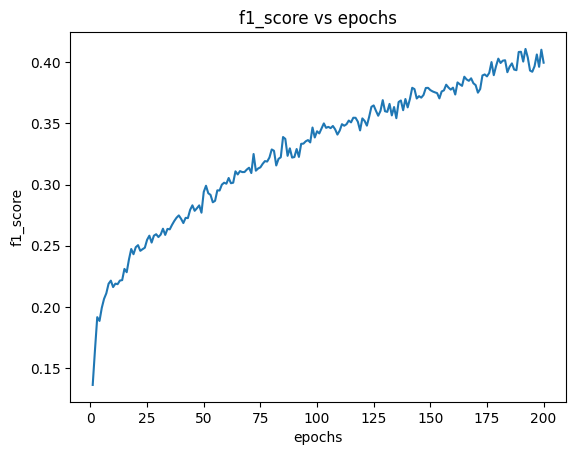

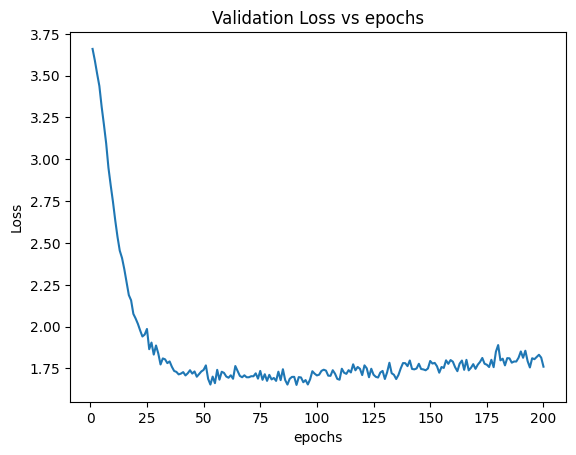

In [6]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

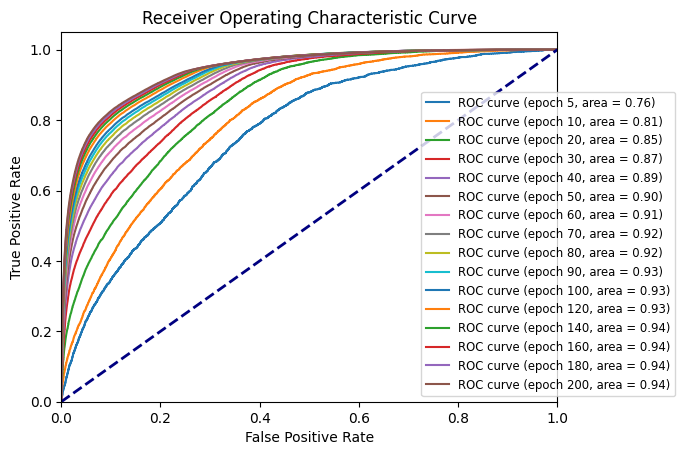

In [7]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)